In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

In [0]:
BATCH_SIZE = 96

In [3]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor()]
)

trainval_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_size = int(len(trainval_dataset) * 0.8)
val_size = int(len(trainval_dataset) * 0.2)
train_dataset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
40000
10000
10000


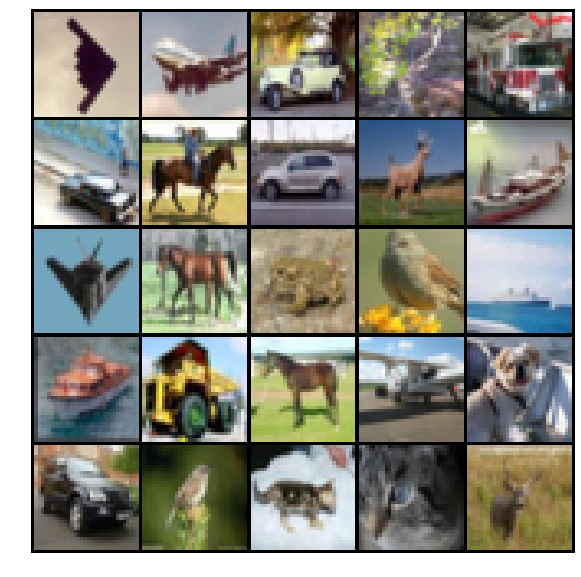

[['plane' 'plane' 'car' 'deer' 'truck']
 ['car' 'horse' 'car' 'deer' 'ship']
 ['plane' 'horse' 'frog' 'bird' 'ship']
 ['ship' 'truck' 'horse' 'plane' 'dog']
 ['car' 'bird' 'cat' 'cat' 'deer']]


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def show_img(x, figsize=(5,5)):
    plt.figure(figsize=figsize)
    if hasattr(x, 'numpy'):
        x = x.numpy()
    x = x.transpose((1, 2, 0))
    x = np.squeeze(x)
    plt.imshow(x)
    plt.axis('off')
    plt.show()
    
dataiter = iter(train_loader)
imgs, labels = dataiter.next()

imgs = imgs[:25]
labels = labels[:25]
grid = torchvision.utils.make_grid(imgs, nrow=5, padding=1)
show_img(grid, figsize=(10, 10))

class_list = [classes[labels[j]] for j in range(25)]
class_list = np.array(class_list)
print(class_list.reshape(5,5))

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Net(nn.Module):
    
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.flatten = Flatten()
        
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x
    


In [0]:
def train(model, device, optimizer, criterion, train_loader, preprocess=None):
    model.train()
    running_loss = 0
    correct = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        
        if preprocess:
            data = preprocess(data)
        
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data)
    
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        running_loss += loss.item()

    train_acc = correct / len(train_loader.dataset)
    train_loss = running_loss / len(train_loader)

    return {'acc':train_acc, 'loss':train_loss}

In [0]:
def validation(model, device, criterion, val_loader, preprocess=None):
    model.eval()
    runnning_loss = 0
    correct = 0
    with torch.no_grad():
        for data, labels in val_loader:
            if preprocess:
                data = preprocess(data)
                
            data, labels = data.to(device), labels.to(device)
            
            output = model(data)
            
            pred = output.argmax(dim=1) 
            correct +=  (pred == labels).sum().item()
            runnning_loss += criterion(output, labels).item()

    val_acc = correct / len(val_loader.dataset)
    val_loss = runnning_loss / len(val_loader)

    return {'acc':val_acc, 'loss':val_loss}

In [0]:
def run(epochs, model, device, optimizer, criterion, train_loader, val_loader, preprocess=None):
    history = {'train_acc':[], 'train_loss':[], 'val_acc':[], 'val_loss':[]}

    for epoch in range(1, epochs+1):
        train_ret = train(model, device, optimizer, criterion, train_loader, preprocess=preprocess)
        val_ret = validation(model, device, criterion, val_loader, preprocess=preprocess)
        
        print("Epoch:{} train_acc:{:.4f}% train_loss:{:.4f} val_acc:{:.4f}% val_loss:{:.4f}".format(
            epoch, train_ret['acc'], train_ret['loss'], val_ret['acc'], val_ret['loss']))

        history['train_acc'].append(train_ret['acc'])
        history['train_loss'].append(train_ret['loss'])
        history['val_acc'].append(val_ret['acc'])
        history['val_loss'].append(val_ret['loss'])
    
    return history

In [9]:
import torch.optim as optim

model = Net()
from torchsummary import summary
summary(model, input_size=(3, 32, 32),  device="cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


epochs = 30

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)

model = model.to(device)
history = run(epochs, model, device, optimizer, criterion, train_loader, val_loader)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 8, 8]         147,584
             ReLU-10            [-1, 128, 8, 8]               0
        MaxPool2d-11            [-1, 128, 4, 4]               0
          Flatten-12                 [-1, 2048]               0
           Linear-13                  [-1, 512]       1,049,088
             ReLU-14                  [

In [0]:
save_model = True
if (save_model):
    torch.save(model.state_dict(),"cifar10.pt")

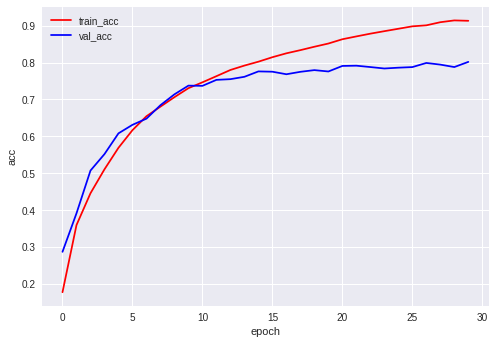

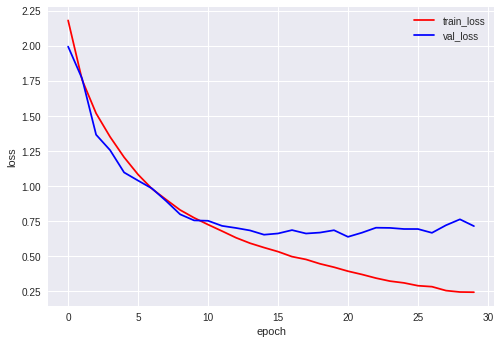

In [11]:
def plot_history(history):
    
    epochs = len(history['train_acc'],)
    
    xaxis = range(epochs)
    plt.figure()
    plt.plot(xaxis, history['train_acc'], 'r-', label='train_acc')
    plt.plot(xaxis, history['val_acc'], 'b-', label='val_acc')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('acc')


    plt.figure()
    plt.plot(xaxis, history['train_loss'], 'r-', label='train_loss')
    plt.plot(xaxis, history['val_loss'], 'b-', label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')

    
plot_history(history)


In [12]:
def test(model, classes, device, criterion, test_loader):
    outsize = len(classes)
    class_correct = list(0. for i in range(outsize))
    class_total = list(0. for i in range(outsize))
    runnning_loss = 0
    with torch.no_grad():
        for data in test_loader:
            imgs, labels = data
            n_batch = imgs.size(0)
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            runnning_loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, 1)
            c = (pred == labels).squeeze()
            for i in range(n_batch):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
    test_acc = int(sum(class_correct)/sum(class_total)*100)
    test_loss = runnning_loss / len(test_loader)
    print('acc  : {:2d}%'.format(test_acc))
    print('loss : {:.4f}'.format(test_loss) )


    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:",device)
model = model.to(device)
test(model, classes, device, criterion, test_loader)

device: cuda
Accuracy of plane : 80 %
Accuracy of   car : 89 %
Accuracy of  bird : 70 %
Accuracy of   cat : 66 %
Accuracy of  deer : 78 %
Accuracy of   dog : 68 %
Accuracy of  frog : 84 %
Accuracy of horse : 83 %
Accuracy of  ship : 87 %
Accuracy of truck : 89 %
acc  : 79%
loss : 0.7281
